# 3 урок: Методы решения проблем при работе с TimeSeries данными

In [1]:
from IPython.display import Image, Math

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

# Что будем делать?

- обучим модель спроса и оценим ее
- обсудим проблемы при работе с TimeSeries данными
- улучшим качество модели путем решения этих проблем

# Задача:

Вам нужно предоставить модель спроса в качестве первого этапа пайплайна динамического ценообразования. Горизонт предсказания - 7 дней вперед. Затем эту модель будут использовать для предсказания спроса при разных ценах.

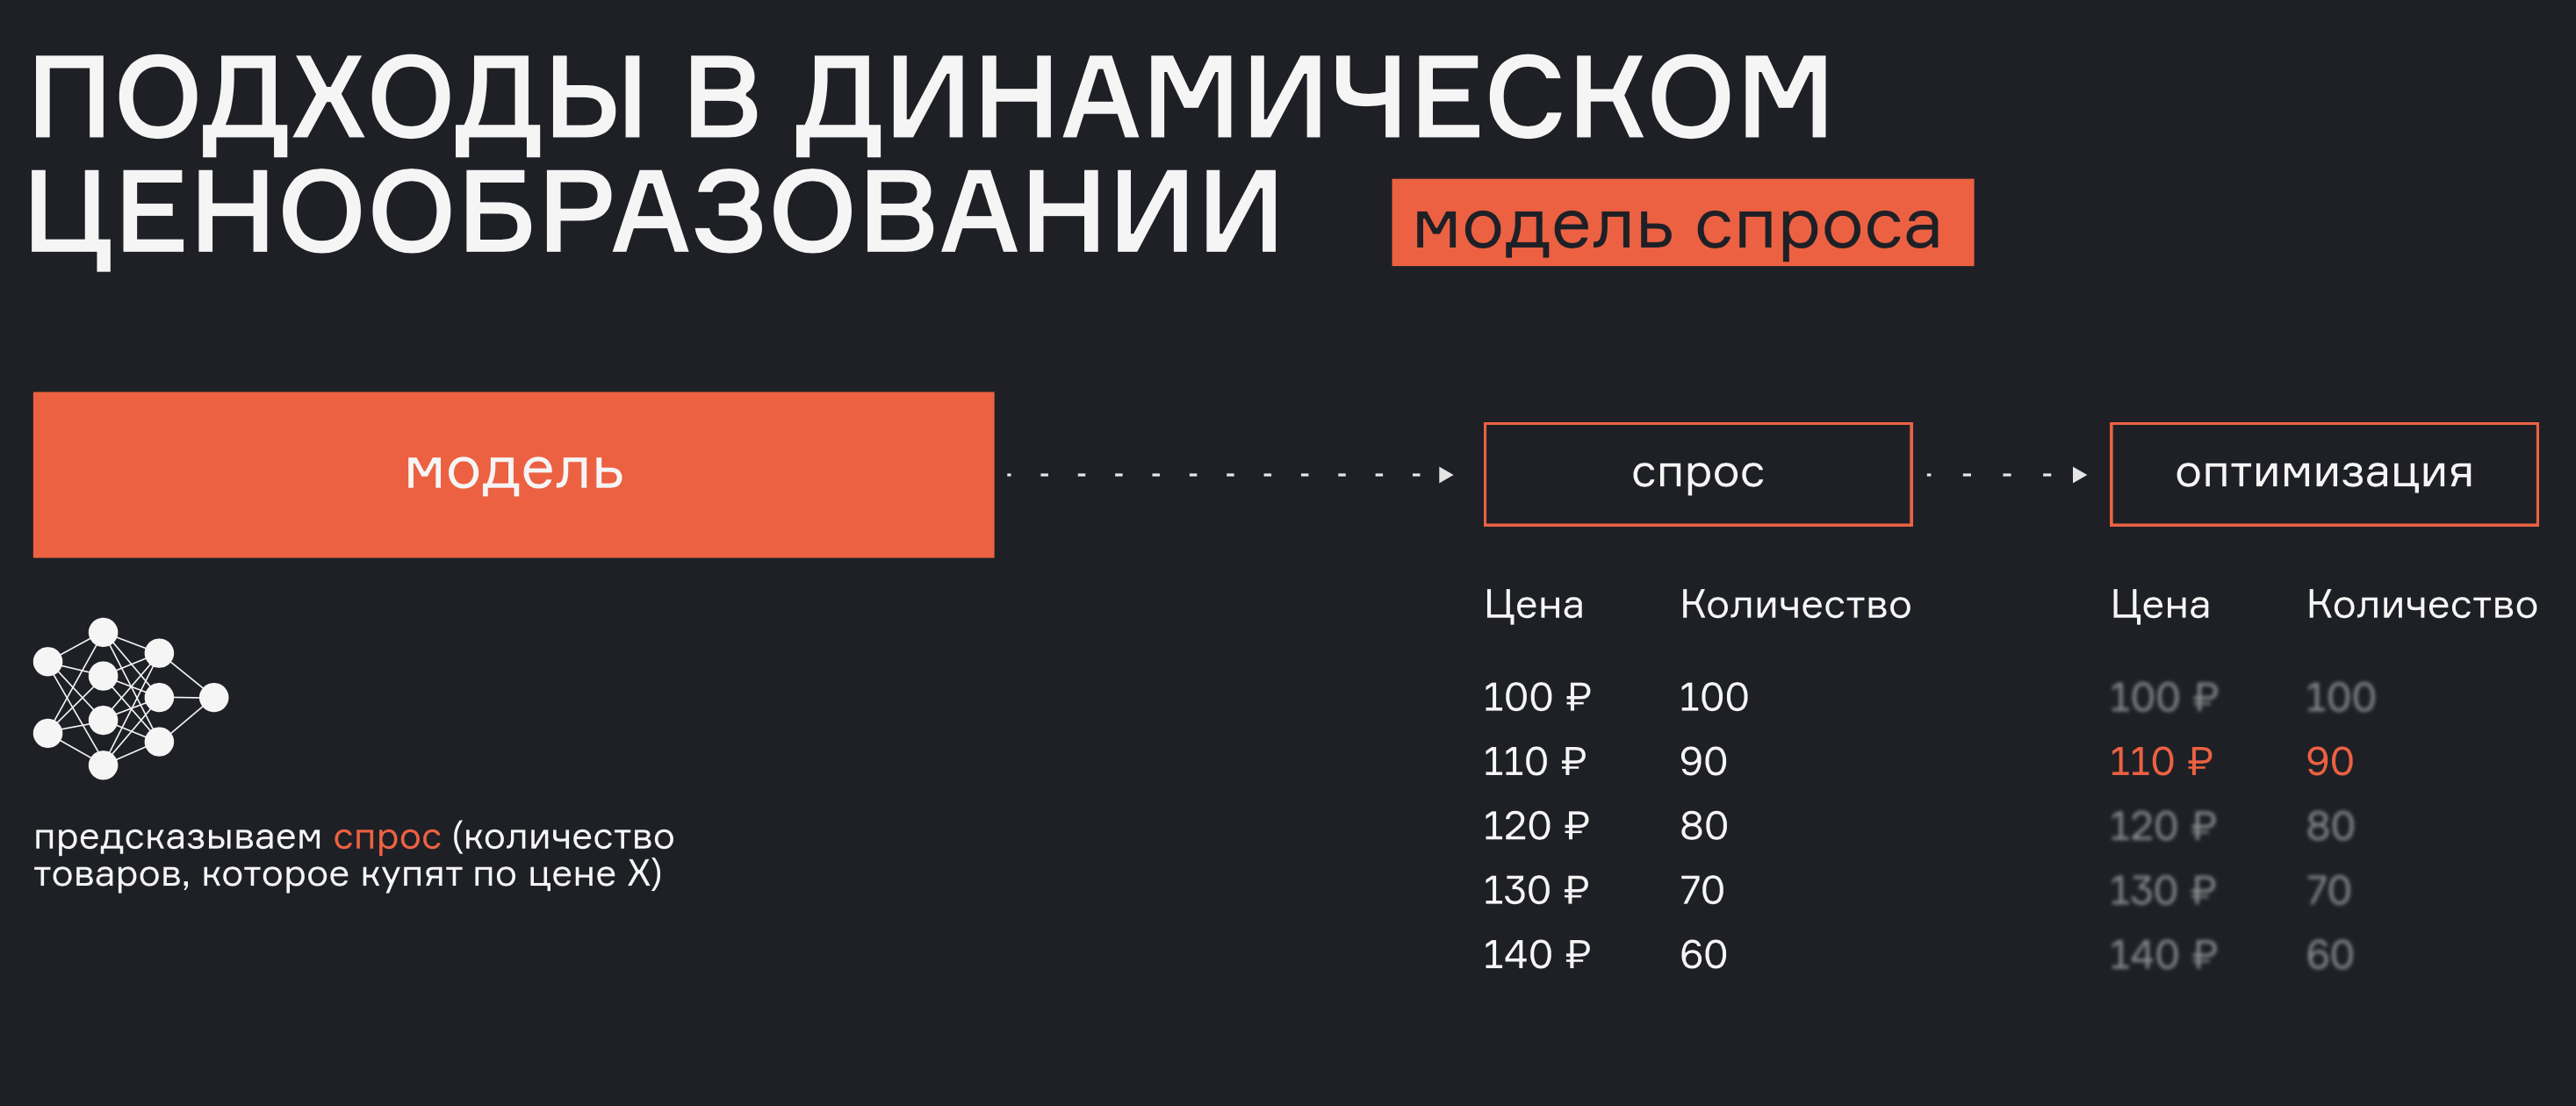

In [2]:
Image("./images/demand_approach.png", width=1000, height=400)

# Данные

<b>sales_cut.parquet</b> - таблица с историей продаж и признаками для модели c 01.01.2021 по 30.06.2021

| Колонка        | Пояснение                                                                                |
|----------------|------------------------------------------------------------------------------------------|
| `sku_id`       | stock keeping unit «единица складского учёта» - идентификатор товарной позиции (артикул) |
| `price`        | цена за дату по товару                                                                   |
| `quantity`     | количество проданного товара за дату                                                     |
| `group`        | категория товара                                                                         |
| `promo`        | название промо для даты                                                                  |
| `feature`      | признак                                                                                  |
| `ds`           | дата                                                                                     |

In [3]:
df = pd.read_parquet("./data/sales_cut.parquet")
df.head()

,sku_id,price,quantity,ds,group,promo,feature
0,208,1074.0,15391.0,20210101,100004,no,153.91
14,135,1113.0,100.0,20210101,100015,no,1.00
17,324,1014.0,17.0,20210101,100000,no,0.17
19,1,1025.0,241.0,20210101,100000,no,2.41
22,161,1007.0,2686.0,20210101,100019,no,26.86


# Обучение модели

In [4]:
# Функция для подсчета MAPE
def calculate_mape(
    df: pd.DataFrame,
    true: str = "quantity",
    pred: str = "pred_quantity",
) -> float:
    df_copied = df.copy(deep=True)
    df_copied = df_copied[df_copied[true] > 0]
    df_copied["mape"] = np.abs(df_copied[true] - df_copied[pred]) / df_copied[true]
    return df_copied["mape"].mean()

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from typing import Tuple

# Функция для TimeSeries кросс-валидации
def get_dfs(
    df: pd.DataFrame,
    n_splits: int,
    test_size: int,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Возвращает 3 датасета: трейн, вал, тест
    """
    # Уникальные даты в датасете
    dates = pd.Series(sorted(df["ds"].unique()))
    # Создание объекта TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    # Проход по разделениям
    for split_id, (train_idxs, test_idxs) in enumerate(tscv.split(dates)):
        train_dates = dates.iloc[train_idxs]
        test_dates = dates.iloc[test_idxs]
        val_dates = train_dates[-test_size:]
        train_dates = train_dates[:-test_size]
        
        logger.info(f"===== SPLIT {split_id} =====")
        logger.info(f"Train: {train_dates.min()} - {train_dates.max()}, size: {train_dates.shape[0]}")
        logger.info(f"Validation: {val_dates.min()} - {val_dates.max()}, size: {val_dates.shape[0]}")
        logger.info(f"Test: {test_dates.min()} - {test_dates.max()}, size: {test_dates.shape[0]}")

        train_df = df[df["ds"].isin(train_dates)]
        val_df = df[df["ds"].isin(val_dates)]
        test_df = df[df["ds"].isin(test_dates)]
        yield train_df, val_df, test_df

In [6]:
from catboost import CatBoost, Pool
from typing import List, Dict, Any, Optional

# Функция для преобразования данных на вход Catboost
def prepare_pool(
    df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    target: Optional[str] = None,
) -> Pool:
    data = df[flt_features + cat_features]
    pool = Pool(
        data=data,
        label=df[target] if target is not None else None,
        cat_features=cat_features,
    )
    return pool
    
# Функция для тренировки модели спроса
def train_model(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    target: str,
    train_params: Dict[str, Any],
) -> CatBoost:
    train_data = train_df[flt_features + cat_features]
    train_pool = prepare_pool(
        df=train_df,
        flt_features=flt_features,
        cat_features=cat_features,
        target=target,
    )
    val_pool = prepare_pool(
        df=val_df,
        flt_features=flt_features,
        cat_features=cat_features,
        target=target,
    )
    model = CatBoost(params=train_params).fit(X=train_pool, eval_set=val_pool)
    return model

# Функция для предсказания спроса с обученной моделью
def predict(
    df: pd.DataFrame,
    model: CatBoost,
    flt_features: List[str],
    cat_features: List[str],
    target: str,
) -> List[float]:
    pool = prepare_pool(
        df=df,
        flt_features=flt_features,
        cat_features=cat_features,
    )
    preds = model.predict(data=pool)
    return preds

In [7]:
from typing import List, Dict, Any, Callable, Optional

# Пайплайн для валидации модели
def run_pipeline(
    df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    train_params: Dict[str, Any],
    target: str,
    n_splits: int,
    test_size: int,
    preprocess_train: Optional[Callable] = None,
    preprocess_train_params: Optional[Dict[str, Any]] = None,
) -> float:
    mapes = []
    for train_df, val_df, test_df in get_dfs(
        df=df,
        n_splits=n_splits,
        test_size=test_size,
    ):
        if preprocess_train is not None and preprocess_train_params is not None:
            train_df = preprocess_train(df=train_df, **preprocess_train_params)
        # Тренируем модель
        model = train_model(
            train_df=train_df,
            val_df=val_df,
            flt_features=flt_features,
            cat_features=cat_features,
            target=target,
            train_params=train_params,
        )
        # Смотрим на важность фичей
        logger.info(model.get_feature_importance(prettified=True).head(10))
        # Предсказываем с помощью обученной модели
        test_df["pred_quantity"] = predict(
            df=test_df,
            model=model,
            flt_features=flt_features,
            cat_features=cat_features,
            target=target,
        )
        # считаем качество
        # лучше считать качество с учетом постпроцессинга (включая clip), но сейчас эти пренебрежём
        mape = calculate_mape(
            df=test_df,
            true="quantity",
            pred="pred_quantity",
        )
        mapes.append(mape)
        logger.info(f"MAPE: {mape}")

    mean_mape = np.mean(mapes)
    logger.info(f"Mean MAPE: {mean_mape}")
    return mean_mape

In [8]:
metric_result = {}

In [9]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "price",
    "feature",
]
CAT_FEATURES = [
    "sku_id",
    "group",
    "promo",
]
TARGET = "quantity"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}
TEST_SIZE = 28
N_SPLITS = 2
mape = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
)
metric_result["Стартовая точка"] = mape

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210101 - 20210407, size: 97
INFO:model:Validation: 20210408 - 20210505, size: 28
INFO:model:Test: 20210506 - 20210602, size: 28


0:	learn: 10.7060766	test: 8.2700490	best: 8.2700490 (0)	total: 159ms	remaining: 2m 38s
100:	learn: 0.8678200	test: 0.6474720	best: 0.6474720 (100)	total: 1.28s	remaining: 11.4s
200:	learn: 0.1430404	test: 0.0986094	best: 0.0986094 (200)	total: 2.33s	remaining: 9.27s
300:	learn: 0.0480179	test: 0.0370256	best: 0.0370256 (300)	total: 3.51s	remaining: 8.14s
400:	learn: 0.0343439	test: 0.0295485	best: 0.0295485 (400)	total: 4.76s	remaining: 7.11s
500:	learn: 0.0303047	test: 0.0263845	best: 0.0263845 (500)	total: 6.05s	remaining: 6.02s
600:	learn: 0.0277108	test: 0.0244952	best: 0.0244952 (600)	total: 7.24s	remaining: 4.81s
700:	learn: 0.0257453	test: 0.0233146	best: 0.0233146 (700)	total: 8.46s	remaining: 3.61s
800:	learn: 0.0244040	test: 0.0224163	best: 0.0224163 (800)	total: 9.74s	remaining: 2.42s
900:	learn: 0.0232513	test: 0.0216751	best: 0.0216751 (900)	total: 11s	remaining: 1.21s


INFO:model:  Feature Id  Importances
0    feature    92.419082
1      group     3.535746
2      promo     1.814503
3      price     1.572282
4     sku_id     0.658386
INFO:model:MAPE: 0.10148696170371771
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210101 - 20210505, size: 125
INFO:model:Validation: 20210506 - 20210602, size: 28
INFO:model:Test: 20210603 - 20210630, size: 28


999:	learn: 0.0222936	test: 0.0210636	best: 0.0210636 (999)	total: 12.2s	remaining: 0us

bestTest = 0.02106359978
bestIteration = 999

0:	learn: 10.1434185	test: 10.0015953	best: 10.0015953 (0)	total: 14.2ms	remaining: 14.2s


100:	learn: 0.8333303	test: 1.0108647	best: 1.0108647 (100)	total: 1.23s	remaining: 10.9s
200:	learn: 0.1378549	test: 0.3398869	best: 0.3398869 (200)	total: 2.38s	remaining: 9.45s
300:	learn: 0.0481593	test: 0.2686293	best: 0.2686293 (300)	total: 3.6s	remaining: 8.36s
400:	learn: 0.0347189	test: 0.2530489	best: 0.2530489 (400)	total: 4.92s	remaining: 7.35s
500:	learn: 0.0313107	test: 0.2666546	best: 0.2521778 (420)	total: 6.35s	remaining: 6.33s


INFO:model:  Feature Id  Importances
0    feature    93.884020
1      group     3.011954
2      promo     2.002519
3      price     1.101508
4     sku_id     0.000000
INFO:model:MAPE: 0.7164047515057352
INFO:model:Mean MAPE: 0.4089458566047265


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2521777893
bestIteration = 420

Shrink model to first 421 iterations.


<font color="red">Качество хорошее, но видим по feature importance, что одна фича вносит сравнимо больший вклад в предсказание (причем, это не цена, как можно было бы ожидать) - выглядит как лик. Посмотрим на корреляцию признаков и целевой переменной:</font>

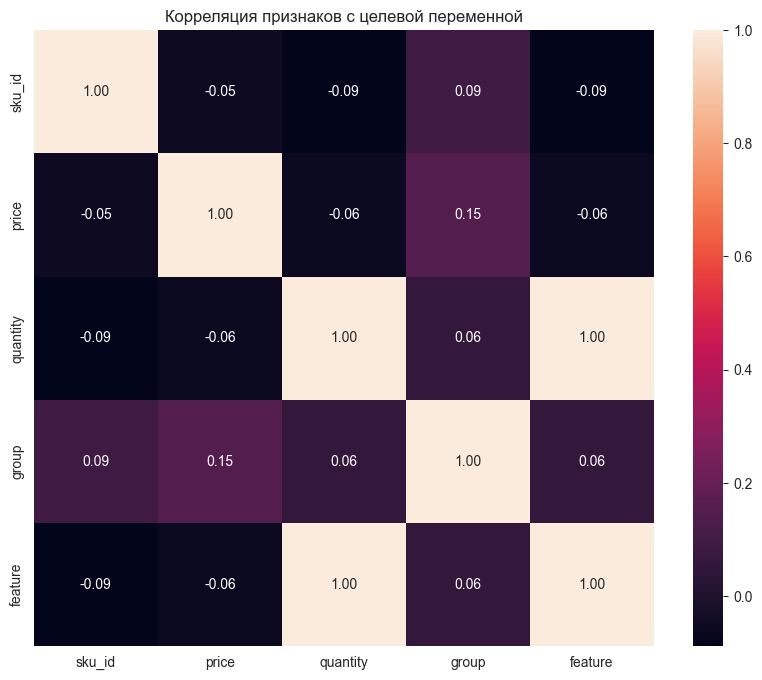

In [10]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Корреляция признаков с целевой переменной")
plt.show()

<font color="red">Видим, что признак "feature" максимально коррелирует с таргетом (коэффициент корреляции = +1) => точно лик, нужно убрать и переобучить модель.</font>

# Проблема #1 Утечка данных (Data Leakage)

<b>Утечка данных</b> - использование информации во время обучения и валидации модели, которая была бы недоступна на этапе прогнозирования.

### Примеры
- если одни и те же шаги предобработки данных применяются к test / train данным, информация из test может случайно использоваться для обучения модели
- если в train данных используется признак, который сильно коррелирует с целевой переменной, и этот признак не будет доступен на момент прогнозирования, то модель может хорошо работать на валидации данных, но плохо на новых данных

### Приемы обнаружения
- метрика качества модели идеальна
- есть признак, который сильно выделяется среди других признаков в feature importance
- крайне высокая корреляция между таргетом и признаками

### Методы борьбы
- валидация набора признаков: с помощью визуализации данных и аналитических методов можно оценить корреляцию между таргетом и признаками
- деление TimeSeries данных по дате, а не случайным образом
- отдельная предобработка данных для каждого набора данных (если используется кросс-валидация, то предобработка должна вызываться на каждом этапе)
- использование forward fill, backward fill запрещен


In [11]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "price",
]
CAT_FEATURES = [
    "sku_id",
    "group",
    "promo",
]
TARGET = "quantity"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}
TEST_SIZE = 28
N_SPLITS = 2
mape = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
)
metric_result["После фикса лика"] = mape

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210101 - 20210407, size: 97
INFO:model:Validation: 20210408 - 20210505, size: 28
INFO:model:Test: 20210506 - 20210602, size: 28


0:	learn: 10.7411645	test: 8.3004284	best: 8.3004284 (0)	total: 13.3ms	remaining: 13.2s
100:	learn: 2.0675817	test: 1.6341609	best: 1.6341609 (100)	total: 1.09s	remaining: 9.75s
200:	learn: 1.5830235	test: 1.2799486	best: 1.2797190 (199)	total: 2.18s	remaining: 8.67s
300:	learn: 1.5117339	test: 1.2592317	best: 1.2584131 (288)	total: 3.35s	remaining: 7.77s


INFO:model:  Feature Id  Importances
0     sku_id    53.656276
1      group    39.579193
2      price     3.689584
3      promo     3.074948
INFO:model:MAPE: 3.1995664154425625
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210101 - 20210505, size: 125
INFO:model:Validation: 20210506 - 20210602, size: 28
INFO:model:Test: 20210603 - 20210630, size: 28


Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.258413103
bestIteration = 288

Shrink model to first 289 iterations.
0:	learn: 10.1473872	test: 10.0027571	best: 10.0027571 (0)	total: 10.6ms	remaining: 10.6s


100:	learn: 1.9472749	test: 2.1561623	best: 2.1561623 (100)	total: 1.13s	remaining: 10.1s
200:	learn: 1.5173194	test: 1.8675207	best: 1.7997413 (189)	total: 2.28s	remaining: 9.07s


INFO:model:  Feature Id  Importances
0     sku_id    48.098060
1      group    47.327925
2      promo     2.804855
3      price     1.769159
INFO:model:MAPE: 2.9321689877629007
INFO:model:Mean MAPE: 3.0658677016027314


Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.799741341
bestIteration = 189

Shrink model to first 190 iterations.


<font color="red">Качество ухудшилось, но feature importance не содержит "фичи-лика", которая все объясняет.</font>

### Лаги и окна
- в лагах / окнах закладывать шифт, равный кол-ву времени, которое нужно предсказать:
    - если предсказывать нужно на 7 дней вперед, нельзя использовать лаг "вчера", так как это значение мы будет знать только для 1 дня, а для 6 других будут пропуски
- окна считаются без учета правой границы периода (без учета текущего дня), если на момент предсказания мы не будем знать информацию об этом значении:
    - окно на основе таргета
- для консистентности данных правильнее считать лаги / окна на основе timestamp, учитывая пропуски:
    - день при лаге 7 дней назад должен быть таким же днем недели, что и текущий, даже если между этими днями вообще не было значений

In [12]:
# Расчет оконных функций
def calc_rolling_window(
    df: pd.DataFrame,
    window: int,
    col: str,
    lvl: str,
    shift: int,
) -> pd.DataFrame:
    df = df.sort_values(["ds", lvl])
    df["ts"] = pd.to_datetime(df["ds"].astype(str))
    df["col"] = df[col]
    rolling_df = df.set_index("ts")
    rolling_df = (
        rolling_df.groupby([lvl], group_keys=True)["col"]
        # используем shift, так как потом нам нужно предсказывать на N дней вперед:
        # для однородности датасета используем сдвиг на кол-во дат в предсказании
        .apply(lambda x: x.asfreq("1D").rolling(window=window, closed="left", min_periods=0).mean().shift(shift))
        .reset_index()
        .rename(columns={"col": f"rolling_{col}_w_{window}"})
    )
    df = df.merge(rolling_df, how="left", on=[lvl, "ts"])
    df = df.drop(columns=["ts", "col"])
    return df

In [13]:
# Добавим в модель средние значения по количеству товаров за окно
for window in [1, 7, 14, 21, 28]:
    df = calc_rolling_window(
        df=df,
        window=window,
        col="quantity",
        lvl="sku_id",
        shift=7,
    )

In [14]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "price",
    "rolling_quantity_w_1",
    "rolling_quantity_w_7",
    "rolling_quantity_w_14",
    "rolling_quantity_w_21",
    "rolling_quantity_w_28",
]
CAT_FEATURES = [
    "sku_id",
    "group",
    "promo",
]
TARGET = "quantity"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}
TEST_SIZE = 28
N_SPLITS = 2
mape = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
)
metric_result["После добавления оконных функций"] = mape

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210101 - 20210407, size: 97
INFO:model:Validation: 20210408 - 20210505, size: 28
INFO:model:Test: 20210506 - 20210602, size: 28


0:	learn: 10.7359012	test: 8.3069927	best: 8.3069927 (0)	total: 12.9ms	remaining: 12.8s
100:	learn: 1.9685421	test: 1.7063900	best: 1.7063900 (100)	total: 1.22s	remaining: 10.8s
200:	learn: 1.4472600	test: 1.4320362	best: 1.4320362 (200)	total: 2.39s	remaining: 9.52s
300:	learn: 1.3618486	test: 1.4191190	best: 1.4191190 (300)	total: 3.58s	remaining: 8.31s
400:	learn: 1.3110867	test: 1.4117879	best: 1.4117879 (400)	total: 4.83s	remaining: 7.22s
500:	learn: 1.2695053	test: 1.4090516	best: 1.4061494 (428)	total: 6.07s	remaining: 6.04s


INFO:model:              Feature Id  Importances
0  rolling_quantity_w_28    16.921686
1  rolling_quantity_w_14    15.036035
2                 sku_id    13.701201
3  rolling_quantity_w_21    12.865588
4                  promo    10.973858
5   rolling_quantity_w_7    10.063194
6                  group     8.643487
7   rolling_quantity_w_1     7.197543
8                  price     4.597409
INFO:model:MAPE: 1.398590224773959
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210101 - 20210505, size: 125
INFO:model:Validation: 20210506 - 20210602, size: 28
INFO:model:Test: 20210603 - 20210630, size: 28


Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.406149448
bestIteration = 428

Shrink model to first 429 iterations.
0:	learn: 10.1691310	test: 10.0061746	best: 10.0061746 (0)	total: 11.7ms	remaining: 11.7s


100:	learn: 1.8785540	test: 1.7382831	best: 1.7382831 (100)	total: 1.22s	remaining: 10.9s
200:	learn: 1.5297224	test: 1.4068927	best: 1.3694497 (186)	total: 2.41s	remaining: 9.59s


INFO:model:              Feature Id  Importances
0  rolling_quantity_w_28    28.067897
1  rolling_quantity_w_14    21.015692
2  rolling_quantity_w_21    18.611295
3   rolling_quantity_w_7    14.749165
4                  promo     5.934650
5                  group     5.224024
6                 sku_id     4.082812
7   rolling_quantity_w_1     1.428727
8                  price     0.885739
INFO:model:MAPE: 1.5875815478023652
INFO:model:Mean MAPE: 1.4930858862881622


Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.369449679
bestIteration = 186

Shrink model to first 187 iterations.


<font color="red">Качество улучшилось за счет новых фичей.</font>

# Проблема #2 Разреженные данные

### Примеры
- в вашем датасете есть товары / услуги, которые продаются редко => много нулей в таргетах

### Приемы обнаружения
- метрика качества модели низкая
- мало данных для обучения там, где продажи ненулевые

### Методы борьбы
- переход на сгруппированные данные
    - по дате (по неделе / месяцу / году)
    - по группе
- downsampling / upsampling

In [15]:
# Снижаем разреженность данных засчет повышения уровня (sku_id -> group)
df = df.groupby(["group", "ds"]).agg({
    "price": "sum",
    "rolling_quantity_w_1": "sum",
    "rolling_quantity_w_7": "sum",
    "rolling_quantity_w_14": "sum",
    "rolling_quantity_w_21": "sum",
    "rolling_quantity_w_28": "sum",
    "promo": "first",
    "quantity": "sum",
}).reset_index()

In [16]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "price",
    "rolling_quantity_w_1",
    "rolling_quantity_w_7",
    "rolling_quantity_w_14",
    "rolling_quantity_w_21",
    "rolling_quantity_w_28",
]
CAT_FEATURES = [
    "group",
    "promo",
]
TARGET = "quantity"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}
TEST_SIZE = 28
N_SPLITS = 2
mape = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
)
metric_result["После группировки данных по категории"] = mape

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210101 - 20210407, size: 97
INFO:model:Validation: 20210408 - 20210505, size: 28
INFO:model:Test: 20210506 - 20210602, size: 28


0:	learn: 8.6260075	test: 5.4384076	best: 5.4384076 (0)	total: 11.6ms	remaining: 11.6s


100:	learn: 1.5023254	test: 1.0400366	best: 1.0400366 (100)	total: 1.02s	remaining: 9.11s
200:	learn: 0.9087108	test: 0.8247482	best: 0.8246378 (199)	total: 2.04s	remaining: 8.1s
300:	learn: 0.8181827	test: 0.8045769	best: 0.7970634 (279)	total: 3.08s	remaining: 7.15s


INFO:model:              Feature Id  Importances
0                  promo    21.704966
1  rolling_quantity_w_14    20.859894
2   rolling_quantity_w_7    16.250673
3                  group    10.063560
4  rolling_quantity_w_21     9.533294
5  rolling_quantity_w_28     9.523944
6                  price     6.338965
7   rolling_quantity_w_1     5.724704
INFO:model:MAPE: 0.923661748459342
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210101 - 20210505, size: 125
INFO:model:Validation: 20210506 - 20210602, size: 28
INFO:model:Test: 20210603 - 20210630, size: 28


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7970634114
bestIteration = 279

Shrink model to first 280 iterations.
0:	learn: 8.0576498	test: 5.1203199	best: 5.1203199 (0)	total: 10.5ms	remaining: 10.5s


100:	learn: 1.2604000	test: 1.0483799	best: 1.0483799 (100)	total: 1.04s	remaining: 9.29s
200:	learn: 0.8201569	test: 0.9191394	best: 0.9191394 (200)	total: 2.07s	remaining: 8.24s
300:	learn: 0.7641429	test: 0.9184070	best: 0.9117783 (254)	total: 3.11s	remaining: 7.22s


INFO:model:              Feature Id  Importances
0  rolling_quantity_w_28    17.754561
1  rolling_quantity_w_21    17.669483
2                  promo    14.221392
3   rolling_quantity_w_7    12.522153
4                  group    11.277629
5  rolling_quantity_w_14    10.984162
6                  price    10.842657
7   rolling_quantity_w_1     4.727963
INFO:model:MAPE: 1.1104248027231949
INFO:model:Mean MAPE: 1.0170432755912684


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9117783449
bestIteration = 254

Shrink model to first 255 iterations.


<font color="red">Качество улучшилось за счет группировки данных. Если вы не удовлетворены качеством прогноза на мелкие единицы, например, товары / услуги, можно делать ценообразование на уровне категорий. Однако, нужно подумать, что можно использовать вместо цены, так как сложно оперировать средней / суммарной ценой на проде. Можно, например, перейти к фиче "скидка" / "наценка".</font>

# Проблема #3 Выбросы

### Примеры
- из-за промо 14 февраля спрос на конфеты вырос в 10 раз
- пришел реселлер и закупился 50 айфонами в один день => рост спроса на айфоны в один день
- баг в данных

### Приемы обнаружения
- визуализация
- дебаг предсказаний (feature importance, качество модели, дебаг отдельных семплов)

### Методы борьбы
- нахождение выбросов и их фильтрация
    - промоакции, выходные, праздники
    - данные, не входящие в межквартильный размах
    - аномалии (например, реселлеры)

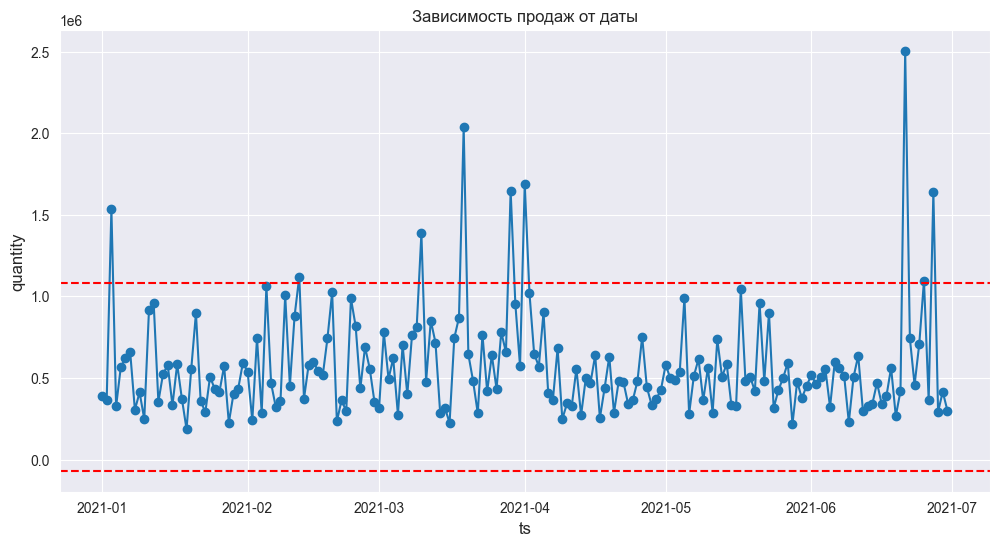

In [17]:
# Нарисуем график зависимости продаж от даты
plot_df = df.copy(deep=True).groupby("ds").agg({"quantity": "sum"}).reset_index()
plot_df["ts"] = pd.to_datetime(plot_df["ds"].astype(str))

# Вычисление квантилей и IQR
q1 = plot_df['quantity'].quantile(0.25)
q3 = plot_df['quantity'].quantile(0.75)
iqr = q3 - q1

# Определение пределов для 1.5 IQR
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

plt.figure(figsize=(12, 6))
plt.plot(plot_df["ts"], plot_df["quantity"], marker='o')
plt.xlabel("ts", fontsize=12)
plt.ylabel("quantity", fontsize=12)
plt.title("Зависимость продаж от даты", fontsize=12)

plt.axhline(y=lower_bound, color='r', linestyle='--')
plt.axhline(y=upper_bound, color='r', linestyle='--')

plt.show()

<font color="red">Выбросы действительно есть, давайте их уберем:</font>

In [18]:
def drop_outliers(
    df: pd.DataFrame,
    lvl: str,
    low_quantile: float,
    high_quantile: float,
) -> pd.DataFrame:
    # Убираем выбросы с помощью квантильного размаха
    df = df.merge(
        df.groupby(lvl)["quantity"].quantile(low_quantile).reset_index().rename(columns={"quantity": "q25"}),
        how="left",
        on=lvl,
    )
    df = df.merge(
        df.groupby(lvl)["quantity"].quantile(high_quantile).reset_index().rename(columns={"quantity": "q75"}),
        how="left",
        on=lvl,
    )
    df = df[
        (df["quantity"] < df["q75"] + 1.5 * (df["q75"] - df["q25"]))
        & (df["quantity"] > df["q25"] - 1.5 * (df["q75"] - df["q25"]))
    ]
    return df

In [19]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "price",
    "rolling_quantity_w_1",
    "rolling_quantity_w_7",
    "rolling_quantity_w_14",
    "rolling_quantity_w_21",
    "rolling_quantity_w_28",
]
CAT_FEATURES = [
    "group",
    "promo",
]
TARGET = "quantity"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}
TEST_SIZE = 28
N_SPLITS = 2
mape = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
    preprocess_train=drop_outliers,
    preprocess_train_params={
        "lvl": "group",
        "low_quantile": 0.25,
        "high_quantile": 0.75,
    }
)
metric_result["После удаление выбросов"] = mape

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210101 - 20210407, size: 97
INFO:model:Validation: 20210408 - 20210505, size: 28
INFO:model:Test: 20210506 - 20210602, size: 28


0:	learn: 8.7088727	test: 5.1794694	best: 5.1794694 (0)	total: 1.96ms	remaining: 1.96s
100:	learn: 1.1675833	test: 0.8850981	best: 0.8850981 (100)	total: 105ms	remaining: 931ms


INFO:model:              Feature Id  Importances
0  rolling_quantity_w_21    20.648742
1                  group    19.760675
2  rolling_quantity_w_28    13.634896
3  rolling_quantity_w_14    13.123421
4                  promo    10.699798
5                  price    10.607276
6   rolling_quantity_w_1     6.584196
7   rolling_quantity_w_7     4.940995
INFO:model:MAPE: 0.8559276247817205
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210101 - 20210505, size: 125
INFO:model:Validation: 20210506 - 20210602, size: 28
INFO:model:Test: 20210603 - 20210630, size: 28


200:	learn: 0.7040095	test: 0.7061092	best: 0.7055663 (199)	total: 207ms	remaining: 825ms
300:	learn: 0.6519674	test: 0.7193881	best: 0.7036945 (219)	total: 312ms	remaining: 724ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.703694482
bestIteration = 219

Shrink model to first 220 iterations.
0:	learn: 8.1093791	test: 4.8408841	best: 4.8408841 (0)	total: 1.91ms	remaining: 1.91s


100:	learn: 1.1341956	test: 0.9475054	best: 0.9475054 (100)	total: 123ms	remaining: 1.09s
200:	learn: 0.7503617	test: 0.7987486	best: 0.7983534 (197)	total: 231ms	remaining: 919ms


INFO:model:              Feature Id  Importances
0  rolling_quantity_w_28    18.076518
1   rolling_quantity_w_7    17.588382
2  rolling_quantity_w_21    14.448836
3                  promo    14.270646
4   rolling_quantity_w_1    10.169045
5                  group     9.938030
6  rolling_quantity_w_14     8.660485
7                  price     6.848059
INFO:model:MAPE: 0.903772804023801
INFO:model:Mean MAPE: 0.8798502144027607


300:	learn: 0.6896100	test: 0.7821139	best: 0.7814555 (290)	total: 335ms	remaining: 778ms
400:	learn: 0.6559764	test: 0.7858074	best: 0.7795363 (311)	total: 452ms	remaining: 675ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7795362568
bestIteration = 311

Shrink model to first 312 iterations.


<font color="red">Качество улучшилось за счет удаления выбросов из train данных.</font>

# Проблема #4 Неправильная предобработка ds-признаков

ds-признаки представляют собой циклические данные, поэтому их нужно отдельно предобрабатывать перед добавлением в модель.

### Примеры
- разница между 23 и 00 часами точно такая же как между 22 и 23

### Приемы обнаружения
- низкое качество предсказания модели
- стоит об этом помнить

### Методы борьбы
- синусоидальное и косинусоидальное преобразование

In [20]:
df["day_of_week"] = pd.DatetimeIndex(df["ds"]).day_of_week
df["day_of_week_sin"] = np.sin((df["day_of_week"] - 1) * (2.0 * np.pi / 7))
df["day_of_week_cos"] = np.cos((df["day_of_week"] - 1) * (2.0 * np.pi / 7))

In [21]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "price",
    "rolling_quantity_w_1",
    "rolling_quantity_w_7",
    "rolling_quantity_w_14",
    "rolling_quantity_w_21",
    "rolling_quantity_w_28",
    "day_of_week_sin",
    "day_of_week_cos",
]
CAT_FEATURES = [
    "group",
    "promo",
]
TARGET = "quantity"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}
TEST_SIZE = 28
N_SPLITS = 2
mape = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
    preprocess_train=drop_outliers,
    preprocess_train_params={
        "lvl": "group",
        "low_quantile": 0.25,
        "high_quantile": 0.75,
    }
)
metric_result["После добавления правильных ds-фич"] = mape

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210101 - 20210407, size: 97
INFO:model:Validation: 20210408 - 20210505, size: 28
INFO:model:Test: 20210506 - 20210602, size: 28


0:	learn: 8.7277152	test: 5.1869802	best: 5.1869802 (0)	total: 1.57ms	remaining: 1.57s
100:	learn: 1.2267119	test: 0.9192769	best: 0.9192769 (100)	total: 108ms	remaining: 962ms


INFO:model:              Feature Id  Importances
0                  group    16.826943
1  rolling_quantity_w_21    15.824141
2  rolling_quantity_w_14    15.490745
3                  promo    11.843658
4  rolling_quantity_w_28    11.647730
5                  price     6.932200
6   rolling_quantity_w_7     6.243517
7        day_of_week_sin     5.886763
8        day_of_week_cos     5.661534
9   rolling_quantity_w_1     3.642770
INFO:model:MAPE: 0.8576825400462496
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210101 - 20210505, size: 125
INFO:model:Validation: 20210506 - 20210602, size: 28
INFO:model:Test: 20210603 - 20210630, size: 28


200:	learn: 0.7383537	test: 0.7294511	best: 0.7294511 (200)	total: 222ms	remaining: 882ms
300:	learn: 0.6498759	test: 0.7415831	best: 0.7281325 (201)	total: 344ms	remaining: 798ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7281325255
bestIteration = 201

Shrink model to first 202 iterations.
0:	learn: 8.1127739	test: 4.8436810	best: 4.8436810 (0)	total: 2.15ms	remaining: 2.15s


100:	learn: 1.1615413	test: 0.9758697	best: 0.9758697 (100)	total: 139ms	remaining: 1.24s
200:	learn: 0.7486609	test: 0.8087790	best: 0.8087790 (200)	total: 278ms	remaining: 1.1s
300:	learn: 0.6700637	test: 0.7904699	best: 0.7891424 (287)	total: 468ms	remaining: 1.08s
400:	learn: 0.6210313	test: 0.7876128	best: 0.7868592 (389)	total: 617ms	remaining: 921ms
500:	learn: 0.5954190	test: 0.7840664	best: 0.7823503 (489)	total: 786ms	remaining: 783ms


INFO:model:              Feature Id  Importances
0  rolling_quantity_w_28    15.406006
1   rolling_quantity_w_7    15.213733
2   rolling_quantity_w_1    13.813792
3                  promo     9.872502
4                  group     9.506539
5  rolling_quantity_w_14     9.371583
6                  price     7.903591
7        day_of_week_sin     6.721314
8  rolling_quantity_w_21     6.548838
9        day_of_week_cos     5.642102
INFO:model:MAPE: 1.0541833577379842
INFO:model:Mean MAPE: 0.9559329488921169


600:	learn: 0.5620415	test: 0.7870146	best: 0.7811359 (552)	total: 980ms	remaining: 651ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7811358525
bestIteration = 552

Shrink model to first 553 iterations.


<font color="red">Качество не улучшилось, но если у вас есть больше данных, можно попробовать добавить ds-фичи, связанные не только с днем недели, но и с неделей, месяцем, годом, сезоном.</font>

# Проблема #5 Пропуски в данных

### Примеры
- пропуски из-за потери части данных

### Приемы обнаружения
- Exploratory Data Analysis (EDA)

### Методы борьбы
- ffill
- заменить на скользящее среднее
- использование методов интерполяции

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   group                  1987 non-null   int64  
 1   ds                     1987 non-null   object 
 2   price                  1987 non-null   float64
 3   rolling_quantity_w_1   1987 non-null   float64
 4   rolling_quantity_w_7   1987 non-null   float64
 5   rolling_quantity_w_14  1987 non-null   float64
 6   rolling_quantity_w_21  1987 non-null   float64
 7   rolling_quantity_w_28  1987 non-null   float64
 8   promo                  1987 non-null   object 
 9   quantity               1987 non-null   float64
 10  day_of_week            1987 non-null   int64  
 11  day_of_week_sin        1987 non-null   float64
 12  day_of_week_cos        1987 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 201.9+ KB


<font color="red">У нас нет пропусков в данных (скорее из-за того, что мы поднялись на уровень группы). Пропускаем этот шаг.</font>

# Итог

In [23]:
for stage, metric_value in metric_result.items():
    print(f"{stage} MAPE={round(metric_value * 100)}%")

Стартовая точка MAPE=41%
После фикса лика MAPE=307%
После добавления оконных функций MAPE=149%
После группировки данных по категории MAPE=102%
После удаление выбросов MAPE=88%
После добавления правильных ds-фич MAPE=96%


<font color="red">Ура! Смогли улучшить качество, но это не предел - можно улучшать дальше.</font>

# Что еще?

- биннинг = разделение признаков на бины
- подбор гиперпараметров
    - optuna, hyperopt, Google Vizier...
- добавление новых фичей
    - окна
    - лаги
    - корреляции
- нормализация и масштабирование данных
    - Min-Max Scaling
    - Standard Scaling
- преобразование признака в явный сигнал модели
    - если важно предсказать, как изменится спрос на изменение цены  - лучше использовать признак "изменение цены" вместо просто "цена"
- работа с категориальными признаками
- фильтрация неважных семплов
    - если важно предсказать, как изменится спрос на изменение цены, то можно выкинуть часть семплов, где цена не меняется
- учитывание тренда
    - если модель не учитывает тренд, то можно использовать домножение на коэффициент тренда
- мало данных для обучения (нет 100%-х хорошо работающих методов аугментации данных, как в CV, из-за чего мы ограничены тем набором данных, что есть)

# Резюме
- в работе с данными TimeSeries есть много подводных камней, но с ними можно справиться
- проверяйте данные на лик
- при разреженных данных можно перейти на уровни выше
- не забывайте фильтровать выбросы
- правильно предобрабатывайте фичи
- пробуйте разные способы обработки пропусков
- больше экспериментируйте, используете разные лайфхаки для улучшений качества модели и у вас обязательно все получится